# Imports

In [ ]:
import pandas as pd
import os,ast, warnings, re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from google.colab import drive
warnings.filterwarnings("ignore")
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
drive.mount('/content/drive')
path = "./drive/MyDrive/NFTS/artists/"

Mounted at /content/drive


In [ ]:
files = [f for f in os.listdir(path)]
dfl = []
for f in files:
    if f == 'collectors.csv':
        pass
    elif f[-4:] == '.csv':
        try:
            dfi = pd.read_csv(path+f)
            dfi['collector'] = f[:-4]
            dfl.append(dfi)
        except:
            pass

In [ ]:
df = pd.concat(dfl)
print(len(df[df['event'] =='C']))
print(len(df[(df['event'] == 'C')&(df['eth_time']!='0')]))
df.reset_index(inplace=True)
print(len(df))
df = df[(df['history'].notna())]
pcWithC = df.groupby('art_piece').history.count()[['C' in l for l in df.groupby('art_piece').event.unique()]].index
df = df.sort_index().reset_index(drop=True)
# df = df[df['art_piece'].isin(pcWithC)]
print(len(df))
del df['index']
del df['tx']
del df['ats']
del df['time']
del df['event']
del df['collector']
for x in df.columns:
    if x[:7] == 'Unnamed':
        del df[x]

1840
1783
8336
8280


# Feature Creation

In [ ]:
df['history'] = df.history.str.replace(' anonymous',' @anonymous')\
.str.replace('\n',' ')

In [ ]:
events = {'made an offer of':'O', 'bought from @': 'B', 'transferred': 'T',
'Auction started by': 'AS','met the reserve price with a bid of':'RM','outbid':'AB',
'won auction with a bid':'AW', 'placed a bid': 'AB','Auction ended':'AE',
'Created by @':'C','accepted an offer of':'A'}

def contain_function(x):
    event = "unknown"
    for key in events:
        if key in x:
            event = events[key]
            break
    return event

df['event'] = df.history.apply(contain_function)

In [ ]:
offer = ['O']
bid = ['AS','RM','AB']
buys = ['B','AW','A']
transaction = ['T','B','AW','A']
df['buy'] = False
df['buy'][df['event'].isin(buys)] = True
df['bid'] = False
df['bid'][df['event'].isin(bid)] = True
df['offer'] = False
df['offer'][df['event'].isin(offer)] = True
df['transaction'] = False
df['transaction'][df['event'].isin(transaction)] = True

In [ ]:
df['eth_price'] = df['eth_price'].str.replace('$','',regex=True)
df['eth_price'] = df['eth_price'].str.replace(',','',regex=True)
df['eth_price'] = df['eth_price'].str.replace(' / ETH','',regex=True)
df['eth_price'] = df['eth_price'].astype(float)
df['eth'].fillna('0')
df['eth'] = df['eth'].astype(float)

In [ ]:
df['eth_time'] = df['eth_time'].fillna('')
eth_time = df['eth_time'].astype(str).apply(lambda st: st[st.find("(")+1:st.rfind("M")+1])
df['eth_time'] = pd.to_datetime(eth_time)#, format='%M-%d-%Y %I:%M:%S %p +0000', utc=True)
df['eth_time'][df['event'] == 'C'] = pd.to_datetime(0)
nullpieces = df[~df['eth_time'].notna()].art_piece.unique()
df = df[~df['art_piece'].isin(nullpieces)]

In [ ]:
df = df.reset_index()

In [ ]:
df['eth'] = df['eth'].astype(float)
df['price'] = df['eth_price'] * df['eth']
df['price'][df['event'] == "C"] = 0
df['price'][df['event'] == "T"] = 0


In [ ]:
avgLSP = df[df['buy'] == True].sort_values('eth_time').groupby\
(['artist','art_piece']).price.last().groupby('artist').mean()

In [ ]:
LSP = df[df['buy'] == True].sort_values('eth_time').groupby\
('artist').price.last()

In [ ]:
#TXCT == TRANSACTION COUNT
rollingTxCt = df[df['transaction']==True].sort_values('eth_time').groupby(['art_piece']).transaction.rolling(99999,min_periods = 1)\
        .sum().reset_index(level = 'art_piece')[['transaction']]
rollingTxCt.columns = ['TxCt']
try:
    del df['TxCt']
except:
    pass
df = df.join(rollingTxCt)
df['TxCt'][df['event'] == 'C'] = 0
df['TxCt'] = df['TxCt'].bfill()
avgASP = df[(df['TxCt'] == float(1))&(df['buy'] == True)].groupby('artist')['price'].mean()


In [ ]:
avgRSP = df[(df['TxCt'] > 1)&(df['buy'] == True)].sort_values('eth_time').groupby\
(['artist','art_piece']).price.last().groupby('artist').mean()

In [ ]:
LPASP = df[(df['TxCt'] == float(1))&(df['price'] > 0)&(df['buy'] == True)].sort_values('eth_time')\
        .groupby('artist')['price'].last()

In [ ]:
transactionVol = df.groupby(['artist','art_piece']).TxCt.max().groupby('artist').mean()

In [ ]:
LSTx = df.groupby('art_piece').TxCt.max()
df['sinceLSD'] = np.where(df['TxCt'] == df['art_piece'].map(LSTx), True, False)
offersSinceLS = df[(df['sinceLSD'] == True)&(df['TxCt'] > 0)].groupby(['artist','art_piece']).offer.sum().groupby('artist').mean()

In [ ]:
artPcCt = df.groupby('artist').art_piece.nunique()
favorites = df.groupby(['artist','art_piece']).favorites.max().groupby('artist').mean()
views = df.groupby(['artist','art_piece']).views.max().groupby('artist').mean()

In [ ]:
auctionedPieces = df[(df['TxCt'] == 1)&(df['event'] == 'AW')].groupby('artist').art_piece.count()
nonAuctionedPieces = df[(df['TxCt'] == 1)&~(df['event'] == 'AW')].groupby('artist').art_piece.count()
txLiftListPrice = df[(df['event'] == 'B')&(df['TxCt'] == float(1))].groupby('artist').buy.sum()/artPcCt


In [ ]:
offersBeforeArtistTx = df[(df['TxCt'] == 0)].groupby(['artist','art_piece']).offer.sum().groupby('artist').mean()

In [ ]:
pcsCreatedLast7 = df[df['eth_time'] >= df['eth_time'].max() - timedelta(days=7)].groupby('artist').art_piece.nunique()
pcsCreatedLast30 = df[df['eth_time'] >= df['eth_time'].max() - timedelta(days=30)].groupby('artist').art_piece.nunique()
pcsCreatedLast180 = df[df['eth_time'] >= df['eth_time'].max() - timedelta(days=180)].groupby('artist').art_piece.nunique()
pcsCreatedLast365 = df[df['eth_time'] >= df['eth_time'].max() - timedelta(days=365)].groupby('artist').art_piece.nunique()

In [ ]:
ats = pd.DataFrame([re.findall(r"@(\w+)", history) for history in df.history.tolist()],columns = ['party1','party2'])
try:
    del df['party1']
    del df['party2']
    df = df.join(ats)
except:
    df = df.join(ats)

In [ ]:
df['consumer'] = None
df['vendor'] = None
df['owner'] = None

df['owner'][df['event'] == 'C'] = df['artist'].str.replace('@','')

df['consumer'][df['event'] == 'A'] = df['party2']
df['owner'][df['event'] == 'A'] = df['consumer']
df['vendor'][df['event'] == 'A'] = df['party1']

df['consumer'][df['event'] == 'B'] = df['party1']
df['owner'][df['event'] == 'B'] = df['consumer']
df['vendor'][df['event'] == 'B'] = df['party2']

df['consumer'][df['event'] == 'T'] = df['party2']
df['owner'][df['event'] == 'T'] = df['party2']
df['vendor'][df['event'] == 'T'] = df['party1']

df['consumer'][df['event'] == 'AW'] = df['party1']
df['owner'][df['event'] == 'AW'] = df['party1']

df['owner'] = df.sort_values('eth_time',ascending=False).groupby('art_piece').owner.transform(lambda v: v.bfill())
df['vendor'][df['event'].isin(['AB','AS','O','RM','C'])] = df['owner']

df['vendor'] = df.sort_values('eth_time',ascending=False).groupby('art_piece').vendor.transform(lambda v: v.bfill())



In [ ]:
unqCollectorsNow = df[df['owner'] != df['artist'].str.replace('@','')].sort_values('eth_time',ascending=False)\
                    .groupby(['artist','art_piece']).owner.first().groupby('artist').nunique()
unqCollectorsAT = df[df['owner'] != df['artist'].str.replace('@','')].groupby(['artist'])\
                    .owner.nunique()
unqPcOwnedByCollectors = df[df['owner'] != df['artist'].str.replace('@','')].sort_values('eth_time',ascending=False)\
                    .groupby(['artist','art_piece']).owner.first().groupby('artist').count()

In [ ]:
offerCtAvg = df.groupby('artist').offer.sum()/df.groupby('artist').art_piece.nunique()

In [ ]:
df['AS'] = False
df['AS'][(df['TxCt'] == 1)&(df['transaction'] == True)] = True

# Value Functions

In [ ]:
illiquid_value = df.sort_values('eth_time').groupby('art_piece').price.rolling(99999,min_periods=1)\
.max().reset_index(level='art_piece').price

illiquid_value = illiquid_value.rename('illiquid_value')
try:
    del df['illiquid_value']
    df = pd.concat([df,illiquid_value],axis =1 )
except:
#     del df['illiquid_value']
    df = pd.concat([df,illiquid_value],axis =1 )

ASP = df[(df['TxCt'] == 1)&(df['buy'] == True)].groupby('art_piece').price.first()
live_illiquids = df[df['art_piece'].isin(ASP.index)]['illiquid_value']\
            .reindex(df.index).fillna(0)
meanLast3ASP = df[(df['TxCt'] == float(1))&(df['price'] > 0)&(df['buy'] == True)].sort_values('eth_time')\
        .groupby('artist')['price'].apply(lambda x: x.tail(3).mean())

# df['value'] = np.log((pd.DataFrame([df['artist'].map(meanLast5ASP),live_illiquids]).max()/
#                       df['art_piece'].map(ASP))+1) * \
#     (df['illiquid_value'] - pd.concat([(df['illiquid_value']/180 * (datetime.today() - df['eth_time']).dt.days)\
#                              .clip(lower = 0),df['price']],axis=1).min(axis=1))

tau = (datetime.today() - df['eth_time']).dt.days
alpha = 25
beta = -.75

## make live illiquid into series with more than just LP
df['value'] = np.log((pd.DataFrame([df['artist'].map(meanLast3ASP),df['illiquid_value']]).max()/
                      df['art_piece'].map(ASP))+1) *\
            (df['illiquid_value'] / (1 + np.exp(-alpha * (tau + beta))))


value = df.groupby('artist').value.mean()
illiquid_value = df.groupby('artist').illiquid_value.mean()

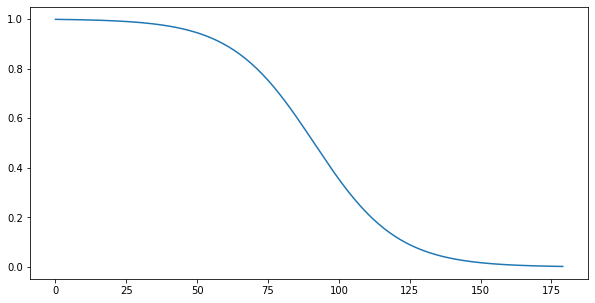

In [ ]:
days = np.arange(180)
tau = (1/365)*(365 - days)
alpha=25
beta = -.75
f = 1/ (1+np.exp(-alpha* (tau + beta)))
plt.figure(figsize=(10,5))
plt.plot(f)
plt.show()

In [ ]:
minidf = df[df['artist'] == '@brickspacer111'][['eth_time','illiquid_value','value']]
minidf = df[df['artist'] == '@femzor'][['eth_time','illiquid_value','value']]


# femzor


In [ ]:
tau = 1/365 * (datetime.today() - minidf['eth_time']).dt.days
alpha = 25
beta = -.75


In [ ]:
adf = pd.concat(\
          [LSP,avgLSP,avgASP,LPASP,avgRSP,transactionVol,artPcCt,favorites,views,offerCtAvg,offersSinceLS,auctionedPieces,\
           nonAuctionedPieces,offersBeforeArtistTx,txLiftListPrice,pcsCreatedLast7,pcsCreatedLast30,\
           pcsCreatedLast180,pcsCreatedLast365,unqCollectorsNow,unqCollectorsAT,unqPcOwnedByCollectors,\
          illiquid_value, value],axis = 1)

adf.columns = ['LSP','avgLSP','avgASP','LPASP','avgRSP','avgTransactionVol','artPcCt','favorites','views',\
               'offerCtAvg','avgOfferCtSinceLS','auctionedPiecesCt','nonAuctionedPiecesCt','avgCtOffersBeforeArtistTx',\
             'pctTxLiftListPrice','pcsCreatedLast7','pcsCreatedLast30','pcsCreatedLast180',\
             'pcsCreatedLast365','unqCollectorsNow','unqCollectorsAT','unqPcOwnedByCollectors',\
              'illiquid_value', 'value']
adf['valOverIlliq'] = adf['value']/adf['illiquid_value']
adf['valPerView'] = adf['value']*adf['views']/adf['artPcCt']
adf=adf[(adf['valOverIlliq'].notna())&(adf['value']>0)]
adf['pctTxLiftListPrice'] = adf['pctTxLiftListPrice'].fillna(0)
adf['pcsCreatedLast7'] = adf['pcsCreatedLast7'].fillna(0)
adf['pcsCreatedLast30'] = adf['pcsCreatedLast30'].fillna(0)
adf['pcsCreatedLast180'] = adf['pcsCreatedLast180'].fillna(0)
adf['pcsCreatedLast365'] = adf['pcsCreatedLast365'].fillna(0)
adf.sort_values('valOverIlliq',ascending=False).head()

,LSP,avgLSP,avgASP,LPASP,avgRSP,avgTransactionVol,artPcCt,favorites,views,offerCtAvg,avgOfferCtSinceLS,auctionedPiecesCt,nonAuctionedPiecesCt,avgCtOffersBeforeArtistTx,pctTxLiftListPrice,pcsCreatedLast7,pcsCreatedLast30,pcsCreatedLast180,pcsCreatedLast365,unqCollectorsNow,unqCollectorsAT,unqPcOwnedByCollectors,illiquid_value,value,valOverIlliq,valPerView
@alex_shell,136.8,48.4,3.9,2.0,59.1,2.8,27,1.1,54.6,1.1,0.1,nan,35.0,0.5,0.5,0.0,0.0,3.0,19,19,35,27,21.4,92.1,4.3,186.1
@alotta_money,56968.9,7985.9,954.2,5229.8,24704.1,1.6,40,9.6,142.9,5.7,0.2,nan,54.0,5.1,0.2,2.0,5.0,14.0,21,18,32,40,2285.4,8751.3,3.8,31274.8
@artonymousartifakt,785.7,298.9,138.6,785.7,1026.9,1.3,133,2.4,53.9,1.8,0.2,nan,152.0,1.4,0.3,1.0,13.0,27.0,49,48,70,115,185.0,629.3,3.4,254.9
@ambiguous,590.0,253.2,170.3,967.6,1105.4,0.4,233,1.0,19.5,0.7,0.0,nan,79.0,0.7,0.0,1.0,10.0,62.0,101,46,57,72,79.2,267.9,3.4,22.4
@coldie,23572.3,6339.3,2504.7,19643.6,16724.7,1.5,110,6.8,151.7,4.3,0.4,5.0,156.0,3.7,0.3,3.0,28.0,52.0,65,54,74,103,2888.7,8186.0,2.8,11288.6


# Matrix analysis


In [ ]:
df[(df['consumer'] == 'matrix')&(df['buy'] == True)]\
.groupby('TxCt').history.nunique()

TxCt
1.0    5
2.0    1
3.0    1
Name: history, dtype: int64

In [ ]:
df[(df['consumer'] == 'matrix')&(df['buy'] == True)]\
.groupby('TxCt').price.median()

TxCt
1.0   908.3
2.0   531.2
3.0    87.0
Name: price, dtype: float64

In [ ]:
df[['favorites','views']].agg(['mean','median','max','min'])

,favorites,views
mean,6.5,92.0
median,4.0,61.0
max,63.0,560.0
min,0.0,1.0


In [ ]:
matrix_flips = df[(df['vendor'] == 'matrix')&(df['buy'] == True)].groupby('art_piece').\
    vendor.sum().str.contains('matrix').index
matrix_solds = df[(df['vendor'] == 'matrix')&(df['buy'] == True)&\
   (df['art_piece'].isin(matrix_flips))].sort_values('eth_time').groupby('art_piece')['price'].first()
matrix_buys = df[(df['consumer'] == 'matrix')&(df['buy'] == True)&\
   (df['art_piece'].isin(matrix_flips))].sort_values('eth_time').groupby('art_piece')['price'].first()

profits = matrix_solds - matrix_buys
profits.sort_values(ascending=False)
viewsfavs = df[df['art_piece'].isin(matrix_flips)].groupby('art_piece')[['views','favorites']].mean()
offerct = df[df['art_piece'].isin(matrix_flips)].groupby('art_piece').offer.sum()
matrix_df = pd.concat([profits,matrix_buys,viewsfavs,offerct],axis=1)
matrix_df.columns = ['profit','purchPrice','views','favorites','offerct']
matrix_df['profitPct'] = (matrix_df['profit']+matrix_df['purchPrice'])/matrix_df['purchPrice']
matrix_df.sort_values('purchPrice')

,profit,purchPrice,views,favorites,offerct,profitPct
d-bit-5796,132.3,87.0,142,5,3,2.5
"pink-tiles,-destruct-10092",nan,nan,87,1,1,nan


In [ ]:
matrix_df.median()

profit       132.3
purchPrice    87.0
views        114.5
favorites      3.0
offerct        2.0
profitPct      2.5
dtype: float64

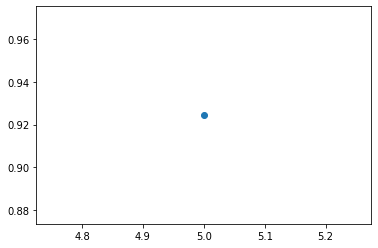

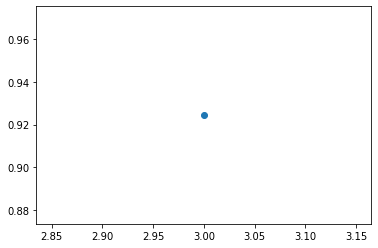

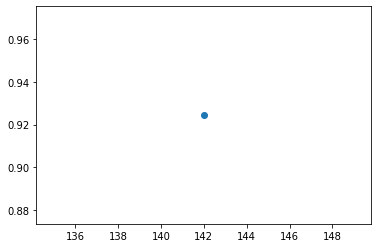

In [ ]:
plt.figure()
plt.scatter(matrix_df['favorites'],np.log(matrix_df['profitPct']))
plt.show()
plt.figure()
plt.scatter(matrix_df['offerct'],np.log(matrix_df['profitPct']))
plt.show()
plt.figure()
plt.scatter(matrix_df['views'],np.log(matrix_df['profitPct']))
plt.show()


In [ ]:
df[(df['art_piece'].isin(matrix_flips))&(df['buy'] == True)&(df['consumer'] == 'matrix')].groupby('art_piece')\
[['views','favorites','price','event','AS']].first().reset_index(level='art_piece')

,art_piece,views,favorites,price,event,AS
0,d-bit-5796,142,5,87.0,B,False


In [ ]:
df[df['art_piece'].isin(df[df['TxCt']>1].art_piece.unique())].groupby('art_piece').offer.sum().agg(['mean','median','max','min'])

mean      2.6
median    2.0
max      24.0
min       0.0
Name: offer, dtype: float64

In [ ]:
df[df['art_piece'].isin(matrix_flips)].groupby('art_piece').offer.sum().agg(['mean','median','max','min'])


mean     2.0
median   2.0
max      3.0
min      1.0
Name: offer, dtype: float64

In [ ]:
df[(df['art_piece'].isin(matrix_flips))&(df['consumer'] == 'matrix')].groupby(['AS','event']).event.count()

AS     event
False  B        1
       T        1
Name: event, dtype: int64

# Overall flipper analysis

In [ ]:
vendors = df['vendor'].unique()
artists = df['artist'].str.replace('@','').unique()

In [ ]:
flippers = [item for item in vendors if item not in artists]

In [ ]:
def valueprofit(collector):
    try:
        flips = df[(df['vendor'] == collector)&(df['buy'] == True)].groupby('art_piece').\
            vendor.sum().str.contains(collector).index
        flips_solds = df[(df['vendor'] == collector)&(df['buy'] == True)&\
           (df['art_piece'].isin(flips))].sort_values('eth_time').groupby('art_piece')['price'].first()
        flips_buys = df[(df['consumer'] == collector)&(df['transaction'] == True)&\
           (df['art_piece'].isin(flips))].sort_values('eth_time').groupby('art_piece')['price'].first()
    except:
        flips_solds, flips_buys = np.array([0]),np.array([0])
    try:
        non_flips_value = df[(np.where(df['TxCt'] == df['art_piece'].map(LSTx), True, False))&\
          (df['owner'] == collector)].groupby('art_piece').value.max()

        non_flips_buys = df[(np.where(df['TxCt'] == df['art_piece'].map(LSTx), True, False))&\
          (df['consumer'] == collector)&(df['buy'] == True)].groupby('art_piece').price.max()
    except:
        non_flips_value, non_flips_buys = np.array([0]),np.array([0])
#     value_profit = flips_solds - flips_buys + non_flips_value - non_flips_buys
#     buys = flips_buys + non_flips_buys
    return flips_solds.sum(), flips_buys.sum(), non_flips_value.sum(), non_flips_buys.sum()

In [ ]:
dfl = []
for f in flippers:
    flips_sold, flips_buy, non_flips_value, non_flips_buy =  valueprofit(f)
    dfl.append([f, flips_sold, flips_buy, non_flips_value, non_flips_buy])

In [ ]:
flipdf = pd.DataFrame(dfl).fillna(0)#.sort_values(1,ascending=False)
flipdf.columns = ['collector','flipS','flipB','nonFlipV','nonFlipB']
flipdf.set_index('collector',inplace=True,drop=True)
flipdf['total_investment'] = flipdf['flipB'] + flipdf['nonFlipB']
flipdf['flip_profit'] = flipdf['flipS'] - flipdf['flipB']
flipdf['value_profit'] = flipdf['nonFlipV'] - flipdf['nonFlipB']
flipdf['total_profit'] = flipdf['flip_profit'] + flipdf['value_profit']
flipdf.drop('anonymous',inplace=True)
flipdf.sort_values('total_profit',ascending=False)

,flipS,flipB,nonFlipV,nonFlipB,total_investment,flip_profit,value_profit,total_profit
collector,,,,,,,,
basileus,123967.4,7289.4,89894.9,17033.7,24323.1,116678.0,72861.3,189539.3
tokenangels,178126.0,2041.3,11437.0,2748.2,4789.5,176084.7,8688.8,184773.6
Cronus,0.0,0.0,134000.8,72.4,72.4,0.0,133928.4,133928.4
vk_crypto,123732.4,1607.9,6725.7,2065.1,3673.0,122124.5,4660.6,126785.1
moderats,0.0,0.0,132952.5,15514.7,15514.7,0.0,117437.9,117437.9
justmatthew,114573.0,2640.2,321.5,141.1,2781.3,111932.8,180.4,112113.2
fafafofo,23572.3,4896.4,146255.2,62210.6,67107.0,18676.0,84044.6,102720.6
BentonCBainbrid,0.0,0.0,95726.1,440.7,440.7,0.0,95285.4,95285.4
lazlonagy,0.0,0.0,87215.7,3792.7,3792.7,0.0,83423.0,83423.0


In [ ]:
# % of A-B % of AS-CS views and favorites and offer ct before first sale and collector cop

In [ ]:
flipdf[['A','AW','B','T']] = 0
flipdf['ASpct'] = 1
for f in flippers:
    event_ct = df[(df['consumer'] == f)&(df['transaction'] == True)\
               ].sort_values('eth_time').groupby('art_piece')[['event','history']].first().groupby('event').nunique()
    ASpct = df[(df['consumer'] == f)&(df['transaction'] == True)].groupby('art_piece')['AS'].sum().mean()

    flipdf['ASPct'] = ASpct
    for event in ['A','AW','B','T']:
        try:
            this_event_ct = event_ct.loc[event].values[0]
            flipdf.loc[f,event] = this_event_ct
        except:
            pass
flipdf['liftPct'] = flipdf['B']/(flipdf['B']+flipdf['A']+flipdf['AW']+flipdf['T'])

In [ ]:
rollingOfferCt = df[df['offer']==True].sort_values('eth_time').groupby(['art_piece']).offer.rolling(99999,min_periods = 1)\
        .sum().reset_index(level = 'art_piece')[['offer']]
rollingOfferCt.columns = ['offerCt']
try:
    del df['offerCt']
except:
    pass
df = df.join(rollingOfferCt)
df['offerCt'][df['event'] == 'C'] = 0
df['offerCt'] = df['offerCt'].bfill()

In [ ]:
viewsFavs = df[df['consumer'].isin(flippers)].groupby(['consumer','art_piece'])[['views','favorites']].mean().groupby('consumer').mean()
viewsFavs.index.rename('collector',inplace = True)
preASOfferCts = df[df['consumer'].isin(flippers)].groupby(['consumer','art_piece']).offerCt.mean().groupby('consumer').mean()
preASOfferCts.index.rename('collector',inplace = True)
flipdf = pd.concat([flipdf,viewsFavs,preASOfferCts],axis=1)
flipdf.drop('anonymous',inplace=True)

# Data Visualization

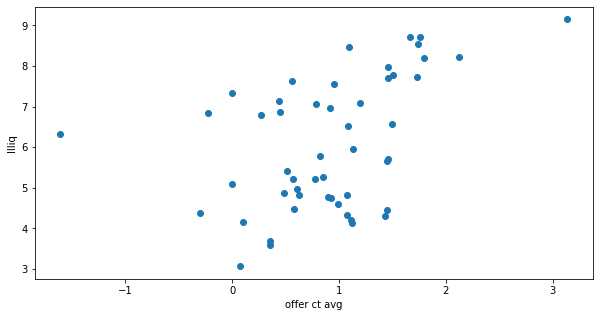

In [ ]:
x = np.log(adf['value']+1)
# x=adf['value']
# x = adf['pctTxLiftListPrice']
y = np.log(adf['illiquid_value'])
x = np.log(adf['offerCtAvg'])

# model = make_pipeline(PolynomialFeatures(2), LinearRegression())
# model.fit(np.array(x).reshape(-1, 1), y)
# x_reg = np.arange(10)
# y_reg = model.predict(x_reg.reshape(-1, 1))


plt.figure(figsize=(10,5))
plt.scatter(x,y)
# plt.colorbar()
# plt.scatter(x_reg,y_reg,s=100)
plt.xlabel('offer ct avg')
plt.ylabel('Illiq')
plt.show()

# Machine Learning yolo

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [ ]:
adf2 = adf[['valOverIlliq','value','views','pctTxLiftListPrice','avgCtOffersBeforeArtistTx',
           'avgTransactionVol','avgOfferCtSinceLS','pcsCreatedLast30']]
adf2['RSOverAS'] = (adf['avgRSP']/adf['avgASP']).fillna(1)
adf2['unqCollectorPct'] = (adf['unqCollectorsNow']/adf['artPcCt'])

In [ ]:
adf2.isnull().sum().sort_values(ascending=False).head()

unqCollectorPct      0
RSOverAS             0
pcsCreatedLast30     0
avgOfferCtSinceLS    0
avgTransactionVol    0
dtype: int64

In [ ]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 5*iqr
    ceiling = q3 + 5*iqr
    outlier_indices = list(x.index[(x<floor)|(x>ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

In [ ]:
indices = []
for col in X.columns:
    tukey_indices, tukey_values = find_outliers_tukey(X[col])
    indices.append(tukey_indices)

indices_set = []
for x in indices:
    for y in x:
        indices_set.append(y)
indices = list(set(indices_set))
for artist in indices:
    adf2 = adf2.drop(artist)

NameError: ignored

In [ ]:
X = adf2.drop('valOverIlliq',1)
y = adf2['valOverIlliq']
y2 = adf2['value']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 1)

In [ ]:
plt.figure()
plt.scatter(X['views'], y2)
plt.show()

In [ ]:
adf2[adf2['value'] <1].sort_values('views',ascending=False)